## Notebook used to make synthetic disease progressions for healthy, LIR & MIR subgroups

In [29]:
# load packages and files

using DifferentialEquations, SciMLBase, Plots, Random # for solving ODEs
using DataFrames
using DataStructures # for the OrderedDict
using LatinHypercubeSampling # for the LHS
using Trapz # for the trapezoidal rule
using CSV # for reading in the parameter distributions of the Ohashi
using Statistics # for the mean and std functions
using JLD2 # for saving the results
Random.seed!(1234)

include("../EDES/including.jl") # for the EDES model 
include("../DataGeneration/AnalyseSynths/SyntheticPatients.jl") # for generating initial states of the synthetic patients
include("../DataGeneration/AnalyseSynths/LocalSensitivity.jl") # for the local sensitivity analysis
include("MIRLIR_progression.jl") # for the MIRLIR disease trajectories
include("../DataGeneration/AnalyseSynths/Realism_inital.jl") # for the analysis of the synthetic patients


ensure_realism_initial (generic function with 3 methods)

In [30]:
# hyperparameters for the data generation
N = 30 # number of patients
BW = 70 
spread_percentage = 0.15

# initial parameters for the synthetic population
distributions_ohashi = CSV.read("./accepted_df_allOHASHI.csv", DataFrame)
initial_k1 = mean(distributions_ohashi[!, "k1"])
initial_k5 = mean(distributions_ohashi[!, "k5"])
initial_k6 = mean(distributions_ohashi[!, "k6"])
# initial_k5 = 0.112
# initial_k6 = 2.03
# initial_k4 = 2.35e-4
# initial_G_liv_b = 0.043
parameter_names = ["k1","k5", "k6"]
initial_people = [initial_k1, initial_k5, initial_k6]
fasting_range_glucose = (4.8, 5.2)
fasting_range_insulin = (7.5, 12.0)

# standard deviations for the parameters, right now
lower_deviations_initial = initial_people .- (initial_people .* spread_percentage )
upper_deviations_initial = initial_people .+ (initial_people .* spread_percentage )


parameter_ranges_initial= OrderedDict( "k1" => (lower_deviations_initial[1], upper_deviations_initial[1]),
                                    "k5" => (lower_deviations_initial[2], upper_deviations_initial[2]),
                                    "k6" => (lower_deviations_initial[3], upper_deviations_initial[3]),
                                   )
fasting_ranges = OrderedDict("fasting_glucose" => fasting_range_glucose, "fasting_insulin" => fasting_range_insulin)


Synthetic_population_healthy = MakePatients(N, parameter_names, parameter_ranges_initial, fasting_ranges, BW = BW);

Check realism for the meal responses of all the initial patients 

In [31]:
boolean_vector = []
for i in 1:length(Synthetic_population_healthy)
    synthetic_patient = Synthetic_population_healthy[i]
    result = ensure_realism_initial(synthetic_patient)
    push!(boolean_vector, result)
end

boolean_vector

insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours


30-element Vector{Any}:
  true
 false
 false
 false
  true
  true
 false
  true
 false
 false
     ⋮
  true
 false
  true
  true
 false
 false
 false
  true
 false

#### visualise OGTT response

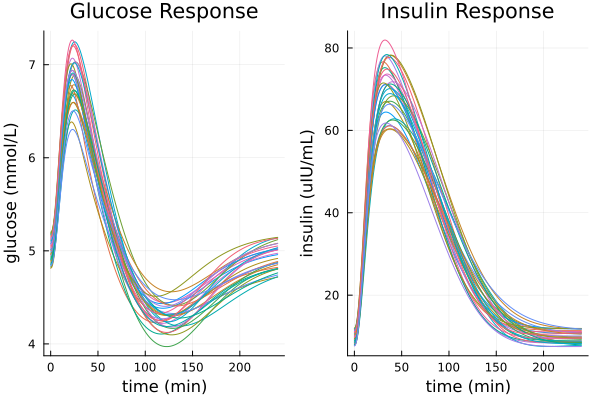

In [32]:
# Assuming Synthetic_population_healthy is a vector of EDES models
# and ParameterValues is a vector of parameter vectors for each patient
glucose_output = PlotMealResponse(
    [Synthetic_population_healthy[i].EDES for i in 1:length(Synthetic_population_healthy)],
    [Synthetic_population_healthy[i].ParameterValues for i in 1:length(Synthetic_population_healthy)]
)

#### Get metabolic values at specific timepoints

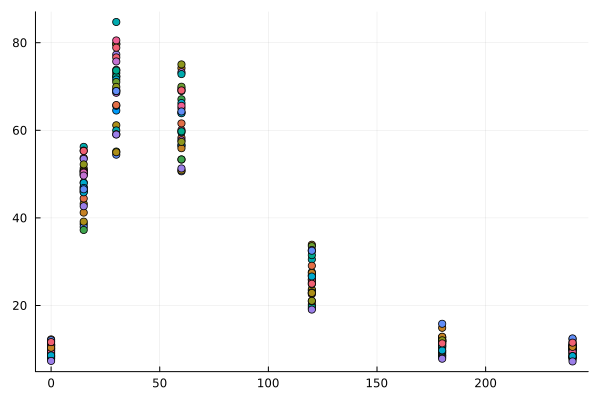

In [33]:
# select timepoints for the output 
timepoints = [0, 15, 30, 60, 120, 180, 240]
variation_G = 0.05
variation_I = 0.10

# get the time 
metabolic_values = [SelectTimePoints(patient, time_points_G = timepoints, time_points_I = timepoints,  variation_G = variation_G,  variation_I = variation_I ) for patient in Synthetic_population_healthy]

figure_glucose = plot()
figure_insulin = plot()
for i in 1:length(metabolic_values)
    scatter!(figure_glucose, timepoints, metabolic_values[i][1], legend = false)
    scatter!(figure_insulin, timepoints, metabolic_values[i][2], label = "insulin", legend = false)
end
figure_glucose
figure_insulin



In [34]:
Synthetic_population_healthy

30-element Vector{SyntheticPatient}:
 SyntheticPatient(EDES(ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, var"#133#134"{Float64, Float64, Float64, Float64, Float64, Float64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}(ODEFunction{true, SciMLBase.AutoSpecialize, var"#133#134"{Float64, Float64, Float64, Float64, Float64, Float64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}, Nothing, Nothing}(var"#133#134"{Float64, Flo

### Save response 


In [35]:
# save to a file

# JLD2.@save "Initial_test_patients.jld2" Synthetic_population_healthy

# Load the data
# loaded_data = JLD2.load("./Metadata/Initial_patients.jld2")["Synthetic_population_healthy"]


### Generate individuals progression

In [39]:
training_data = JLD2.load("./Metadata/Initial_training_patients.jld2")["Synthetic_population_healthy"]
test_data = JLD2.load("./Metadata/Initial_test_patients.jld2")["Synthetic_population_healthy"]

# seperate the training data into MIR LIR & healthy
for i in 1:length(training_data)
    if i % 3 == 1
        println("Group 1: Patient $i")
    elseif i % 3 == 2
        println("Group 2: Patient $i")
    else
        println("Group 3: Patient $i")
    end
end

Group 1: Patient 1
Group 2: Patient 2
Group 3: Patient 3
Group 1: Patient 4
Group 2: Patient 5
Group 3: Patient 6
Group 1: Patient 7
Group 2: Patient 8
Group 3: Patient 9
Group 1: Patient 10
Group 2: Patient 11
Group 3: Patient 12
Group 1: Patient 13
Group 2: Patient 14
Group 3: Patient 15
Group 1: Patient 16
Group 2: Patient 17
Group 3: Patient 18
Group 1: Patient 19
Group 2: Patient 20
Group 3: Patient 21
Group 1: Patient 22
Group 2: Patient 23
Group 3: Patient 24
Group 1: Patient 25
Group 2: Patient 26
Group 3: Patient 27
Group 1: Patient 28
Group 2: Patient 29
Group 3: Patient 30
Group 1: Patient 31
Group 2: Patient 32
Group 3: Patient 33
Group 1: Patient 34
Group 2: Patient 35
Group 3: Patient 36
Group 1: Patient 37
Group 2: Patient 38
Group 3: Patient 39
Group 1: Patient 40
Group 2: Patient 41
Group 3: Patient 42
Group 1: Patient 43
Group 2: Patient 44
Group 3: Patient 45
Group 1: Patient 46
Group 2: Patient 47
Group 3: Patient 48
Group 1: Patient 49
Group 2: Patient 50
Group 3: 